In [2]:
import pandas as pd

In [4]:
df_factors = pd.read_csv('df_energy_factors.csv')
df_forecast = pd.read_csv('df_lstm_total_energy_forecast.csv')
df_forecast = df_forecast[df_forecast['predicted_total_energy'].notna()].reset_index(drop=True)

C:\Users\chen\AppData\Local\Temp\ipykernel_21080\2995844991.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_factors = pd.read_csv('df_energy_factors.csv')


In [5]:
df_factors.columns = df_factors.columns.str.lower()
df_forecast.columns = df_forecast.columns.str.lower()

In [6]:
df_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854276 entries, 0 to 854275
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   unnamed: 0                  854276 non-null  int64  
 1   energy_consumption_current  854276 non-null  int64  
 2   property_type               854276 non-null  object 
 3   built_form                  854276 non-null  object 
 4   construction_age_band       847570 non-null  object 
 5   total_floor_area            854276 non-null  float64
 6   floor_level                 692550 non-null  object 
 7   flat_top_storey             224305 non-null  object 
 8   floor_height                287314 non-null  float64
 9   extension_count             754448 non-null  float64
 10  number_habitable_rooms      754448 non-null  float64
 11  number_heated_rooms         754448 non-null  float64
 12  heat_loss_corridor          672648 non-null  object 
 13  glazed_type   

In [7]:
df_factors.columns.to_list()

['unnamed: 0',
 'energy_consumption_current',
 'property_type',
 'built_form',
 'construction_age_band',
 'total_floor_area',
 'floor_level',
 'flat_top_storey',
 'floor_height',
 'extension_count',
 'number_habitable_rooms',
 'number_heated_rooms',
 'heat_loss_corridor',
 'glazed_type',
 'glazed_area',
 'multi_glaze_proportion',
 'windows_energy_eff',
 'walls_energy_eff',
 'roof_energy_eff',
 'floor_energy_eff',
 'mainheat_description',
 'main_heating_controls',
 'hotwater_description',
 'low_energy_lighting',
 'lighting_energy_eff',
 'solar_water_heating_flag',
 'photo_supply',
 'mechanical_ventilation',
 'inspection_date',
 'year',
 'local_authority',
 'transaction_type',
 'building_reference_number',
 'population',
 'main_fuel',
 'tenure']

In [12]:
df_factors['main_fuel'].unique()

array(['mains gas (not community)',
       'mains gas - this is for backwards compatibility only and should not be used',
       'oil (not community)', 'electricity (not community)', 'NO DATA!',
       'mains gas (community)',
       'Electricity: electricity, unspecified tariff',
       'To be used only when there is no heating/hot-water system',
       'house coal (not community)', 'dual fuel - mineral + wood',
       'LPG (not community)', 'Gas: mains gas', 'wood logs',
       'LPG - this is for backwards compatibility only and should not be used',
       'LPG special condition', 'electricity (community)',
       'biomass (community)', 'smokeless coal', 'bottled LPG',
       'anthracite', 'LPG (community)', 'B30D (community)', 'INVALID!',
       'To be used only when there is no heating/hot-water system or data is from a community network',
       'oil (community)', 'Solid fuel: wood logs', 'bulk wood pellets',
       'Gas: bulk LPG', 'from heat network data (community)',
       'B3

In [14]:
# 'electricity (not community)'
# 'Electricity: electricity, unspecified tariff'
# 'electricity (community)'

In [16]:
df_factors['main_fuel'].nunique()

38

In [18]:
df_factors['local_authority'].unique()

array(['E08000001', 'E08000002', 'E08000003', 'E08000004', 'E08000005',
       'E08000006', 'E08000007', 'E08000008', 'E08000009', 'E08000010'],
      dtype=object)

# Step1: Share of electricity current/future

In [21]:
# 1. identify electricity fuel
electric_keywords = ['electric', 'electricity']
df_factors['is_electric'] = df_factors['main_fuel'].str.lower().apply(
    lambda x: any(keyword in x for keyword in electric_keywords)
)
# 2. calculate current electricity share by regions (baseline)
df_base_electric_share = (
    df_factors.groupby('local_authority')['is_electric']
    .mean()
    .reset_index()
    .rename(columns = {'is_electric': 'base_electricity_share'})
)
# 3. 3 electrification scenarios
years = list(range(2024, 2036))
scenarios = {
    'A': 0.70, # steady progress
    'B': 0.90, # policy driven
    'C': 0.60 # conservative
}

In [23]:
# interpolation for electrification share by years
df_path = []

for _, row in df_base_electric_share.iterrows():
    loc = row['local_authority']
    base = row['base_electricity_share']
    for y in years:
        for s, target in scenarios.items():
            share = base + (target - base) * (y - 2023) / (2035 - 2023)
            df_path.append({
                'local_authority': loc,
                'year': y,
                f'electric_share_{s}': share
            })

# merge 3 scenarios
df_path = pd.DataFrame(df_path)
df_path = df_path.pivot_table(index=['local_authority', 'year'], aggfunc = 'first').reset_index()

# part results
df_path.head()

,local_authority,year,electric_share_A,electric_share_B,electric_share_C
0,E08000001,2024,0.160589,0.177255,0.152255
1,E08000001,2025,0.209626,0.242959,0.192959
2,E08000001,2026,0.258663,0.308663,0.233663
3,E08000001,2027,0.307701,0.374368,0.274368
4,E08000001,2028,0.356738,0.440072,0.315072


# Step2: Calculate increased electricity demand, 3 scenarios

In [26]:
# merge forecast energy with above paths
df_merged = pd.merge(df_forecast, df_path, on = ['local_authority', 'year'], how = 'left')

# merge current electricity share
df_merged = pd.merge(df_merged, df_base_electric_share, on = 'local_authority', how = 'left')
# new col, total electricity demand existing, baseline
df_merged['electric_demand_current'] = (
    df_merged['predicted_total_energy'] * df_merged['base_electricity_share']
)

# increased demand = total energy yearly *(yearly share - baseline) / cop
COP = 3
for scenario in ['A', 'B', 'C']:
    df_merged[f'electric_demand_{scenario}'] = (
        df_merged['predicted_total_energy'] *
        (df_merged[f'electric_share_{scenario}'] - df_merged['base_electricity_share']) / COP
    ).clip(lower = 0) #　avoid negative values

# total demand = current demand + increased demand
for scenario in ['A', 'B', 'C']:
    df_merged[f'electric_total_{scenario}'] = (
        df_merged['electric_demand_current'] + df_merged[f'electric_demand_{scenario}']
    )
# output
df_result_sample = df_merged[['local_authority', 'year', 'predicted_total_energy', 'electric_demand_current',
                             'electric_share_A', 'electric_demand_A', 'electric_total_A',
                             'electric_share_B', 'electric_demand_B', 'electric_total_B',
                             'electric_share_C', 'electric_demand_C', 'electric_total_C']].head(5)
print(df_result_sample)

  local_authority  year  predicted_total_energy  electric_demand_current  \
0       E08000001  2024            1.455024e+08             1.623098e+07   
1       E08000001  2025            1.441228e+08             1.607708e+07   
2       E08000001  2026            1.437851e+08             1.603941e+07   
3       E08000001  2027            1.434858e+08             1.600603e+07   
4       E08000001  2028            1.432900e+08             1.598418e+07   

   electric_share_A  electric_demand_A  electric_total_A  electric_share_B  \
0          0.160589       2.378352e+06      1.860933e+07          0.177255   
1          0.209626       4.711603e+06      2.078868e+07          0.242959   
2          0.258663       7.050846e+06      2.309026e+07          0.308663   
3          0.307701       9.381560e+06      2.538759e+07          0.374368   
4          0.356738       1.171094e+07      2.769512e+07          0.440072   

   electric_demand_B  electric_total_B  electric_share_C  electric_demand_

In [28]:
# export main cols
output_columns = [
    'local_authority', 'year', 'predicted_total_energy',
    'base_electricity_share', 'electric_demand_current',
    'electric_share_A', 'electric_demand_A', 'electric_total_A',
    'electric_share_B', 'electric_demand_B', 'electric_total_B',
    'electric_share_C', 'electric_demand_C', 'electric_total_C'
]

df_export = df_merged[output_columns].reset_index(drop = True)
df_export.to_csv('electricity_demand_scenarios_2024_2035.csv', index = False)

# Step3: Results analysis

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
# all demand by years under 3 scenarios
df_export = pd.read_csv('electricity_demand_scenarios_2024_2035.csv')

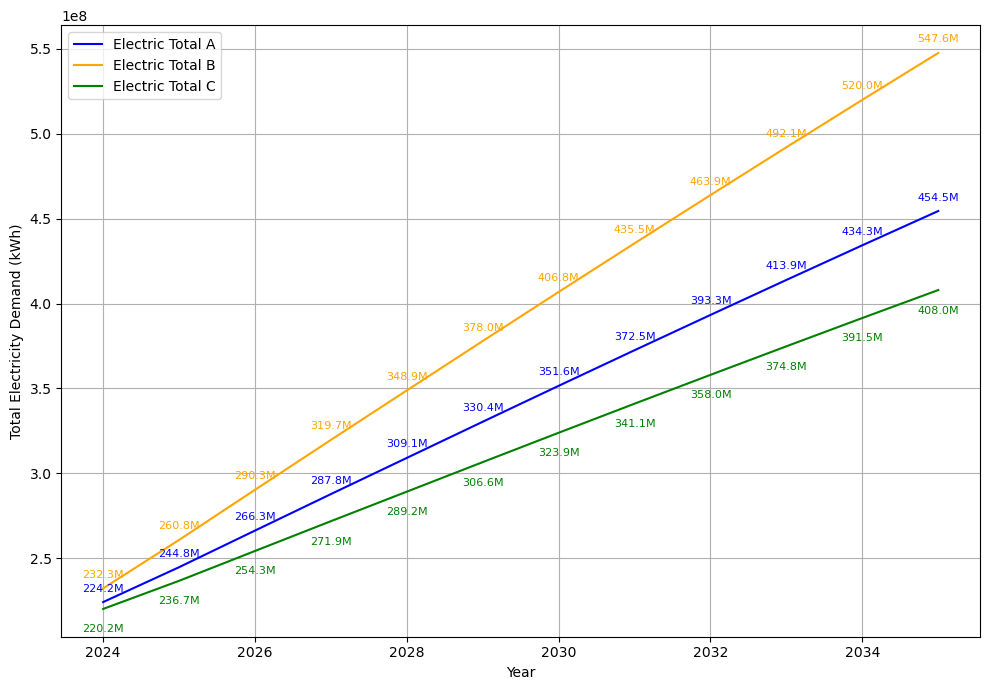

In [33]:
# toal elec demand
df_summary = df_export.groupby('year')[
    ['electric_total_A', 'electric_total_B', 'electric_total_C']
].sum().reset_index()


plt.figure(figsize=(10, 7))
# labels location
scenarios = [
    ('electric_total_A', 'blue', 5e6),
    ('electric_total_B', 'orange', 5e6),
    ('electric_total_C', 'green', -15e6)
]


for scenario, color, y_offset in scenarios:
    plt.plot(df_summary['year'], df_summary[scenario], 
             label=scenario.replace('_', ' ').title(), color=color)
    for x, y in zip(df_summary['year'], df_summary[scenario]):
        plt.text(x, y + y_offset, f'{y/1e6:.1f}M', fontsize=8, 
                 color=color, ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Total Electricity Demand (kWh)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# select 2035 data
df_2035 = df_export[df_export['year'] == 2035].copy()
cols = [
    'local_authority',
    'electric_demand_A','electric_demand_B','electric_demand_C',
    'electric_total_A','electric_total_B','electric_total_C'
]
# extract and sort
df_report = df_2035[cols].sort_values('electric_total_B', ascending=False).reset_index(drop=True)

# export
df_report.to_csv('electric_demand_2035_by_district.csv', index=False)
print(df_report)

  local_authority  electric_demand_A  electric_demand_B  electric_demand_C  \
0       E08000003       4.042500e+07       5.833331e+07       3.147085e+07   
1       E08000006       2.120856e+07       3.105004e+07       1.628781e+07   
2       E08000001       2.792275e+07       3.741304e+07       2.317760e+07   
3       E08000007       2.746830e+07       3.680008e+07       2.280241e+07   
4       E08000010       2.718472e+07       3.585374e+07       2.285021e+07   
5       E08000008       2.527101e+07       3.334877e+07       2.123213e+07   
6       E08000004       2.741149e+07       3.584414e+07       2.319516e+07   
7       E08000002       2.315056e+07       3.071345e+07       1.936912e+07   
8       E08000005       2.372679e+07       3.119081e+07       1.999479e+07   
9       E08000009       1.761636e+07       2.391162e+07       1.446873e+07   

   electric_total_A  electric_total_B  electric_total_C  
0      1.071872e+08      1.250955e+08      9.823306e+07  
1      6.091850e+07      